In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [2]:
%matplotlib inline
import os
import operator
import numpy as np
import pandas as pd
from football_loader import metrics


def load_league_csv(league, start_year=2005):
    df = None
    files = os.listdir(f'fulldata/{league}')
    files.sort()
    for file in files:
        year = int(file.strip('.csv'))
        if year < start_year:
            continue
        df_year = pd.read_csv(f'fulldata/{league}/' + file,
                              engine='python',
                              # skiprows=1,
                              # index_col=None,
                              # names=['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
                              )
        df_year.reset_index(drop=True, inplace=True)
        df_year['Year'] = year
        df_year['Match'] = df_year.index + 1

        if df is None:
            df = df_year
        else:
            df = df.append(df_year, ignore_index=True, sort=False)

    # print(len(df))
    # print(df.shape)

    # remove unused columns
    # df_league = None
    df.reset_index(inplace=True)
    # df = df[['Year', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    #          "B365H", "B365D", "B365A"]]
    return df


def make_features(df, teams):
    # df_league = None
    ret = {}

    # if teams is None:
    #     teams = np.unique(df.loc[df['Year'] == predict_year, 'HomeTeam'].values)
    #     teams.sort()
    for team in teams:

        df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        all = pd.DataFrame(
            data={
                'Year': df_team['Year'],
                'Date': df_team['Date'],
                'Team': team,
                'HomeMatch': df_team['HomeTeam'] == team
            }
        )
        all['Opponent'] = np.where(all['HomeMatch'], df_team['AwayTeam'], df_team['HomeTeam'])
        # X['HalfTimeGoals'] = np.where(X['HomeMatch'], df_team['HTHG'], df_team['HTAG'])
        # X['HalfTimeOpponentGoals'] = np.where(X['HomeMatch'], df_team['HTAG'], df_team['HTHG'])
        # X['HalfTimeLead'] = X['HalfTimeGoals'] > X['HalfTimeOpponentGoals']
        # X['HalfTimeLeadMoreThanTwo'] = (X['HalfTimeGoals'] - X['HalfTimeOpponentGoals']) > 2
        # X['FullTimeGoals'] = np.where(X['HomeMatch'], ath_madrid['FTHG'], ath_madrid['FTAG'])
        # X['FullTimeOpponentGoals'] = np.where(X['HomeMatch'], ath_madrid['FTAG'], ath_madrid['FTHG'])
        all['FTR'] = df_team['FTR']
        # all['Won'] = np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A')
        all['Won'] = np.where(df_team['FTR'] == '', False, np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A'))
        all['Draw'] = np.where(df_team['FTR'] == '', False, df_team['FTR'] == 'D')
        all['Lost'] = np.where(df_team['FTR'] == '', False, np.where(all['HomeMatch'], df_team['FTR'] == 'A', df_team['FTR'] == 'H'))
        all['Result'] = np.where(df_team['FTR'] == '', '', np.where(all['Won'], 'Win', (np.where(all['Lost'], 'Lose', 'Draw'))))
        # X['SumGoals'] = X.groupby('Opponent')['FullTimeGoals'].transform(sum)
        all['B365Max'] = np.maximum(np.maximum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Min'] = np.minimum(np.minimum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Say'] = np.where(all['HomeMatch'],
                                  # home match
                                  np.where(all['B365Max'] == df_team['B365H'], -1,
                                           np.where(all['B365Max'] == df_team['B365A'], 1,
                                                    0)),
                                  # away match
                                  np.where(all['B365Max'] == df_team['B365H'], 1,
                                           np.where(all['B365Max'] == df_team['B365A'], -1,
                                                    0))
                                  )
        # all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Max'] - all['B365Min'],
        #                            all['B365Min'] - all['B365Max'])
        all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Min'] - all['B365Max'],
                                   np.where(all['B365Say'] == -1, all['B365Max'] - all['B365Min'],
                                            # draw
                                            np.where(all['HomeMatch'],
                                            df_team['B365A'] - df_team['B365H'],
                                            df_team['B365H'] - df_team['B365A']
                                            ))) * -1
        all['Corners'] = np.where(all['HomeMatch'], df_team['HC'], df_team['AC'])
        all['Shots'] = np.where(all['HomeMatch'], df_team['HS'], df_team['AS'])
        all['ShotsOnTarget'] = np.where(all['HomeMatch'], df_team['HST'], df_team['AST'])
        all['Points'] = np.where(all['Won'], 3,
                                 np.where(all['Draw'], 1, 0)
                                  )
        all['AdjustedPoints'] = np.where(all['HomeMatch'],
                                  # home match
                                         np.where(all['Won'], 1,
                                                  np.where(all['Draw'], 0, -1)
                                                  )
                                         ,
                                  # away match
                                         np.where(all['Won'], 1.5,
                                                  np.where(all['Draw'], 0.5, 0)
                                                  )
                                  )
        all['Goals'] = np.where(all['HomeMatch'], df_team['FTHG'], df_team['FTAG'])
        all['Conceded'] = np.where(all['HomeMatch'], df_team['FTAG'], df_team['FTHG'])

        # find number of times won against this opponent in last 5 meetings
        for key, groupByOpponent in all.groupby('Opponent'):
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByOpponent.index

            # make match day an index because rolling need an index date
            xx = groupByOpponent.set_index('Date')
            xx['idx'] = idx
            # shift to exclude self
            xx['Last5AgainstThisOpponentWon'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last5AgainstThisOpponentDraw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['Last5AgainstThisOpponentLost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['Last3AgainstThisOpponentWon'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last3AgainstThisOpponentDraw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['LastAgainstThisOpponentWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['LastAgainstThisOpponentDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['LastThisOpponentLost'] = xx['Lost'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            all.loc[xx.index, 'Last5AgainstThisOpponentWon'] = xx['Last5AgainstThisOpponentWon']
            all.loc[xx.index, 'Last5AgainstThisOpponentDraw'] = xx['Last5AgainstThisOpponentDraw']
            # X.loc[xx.index, 'Last5AgainstThisOpponentLost'] = xx['Last5AgainstThisOpponentLost']
            all.loc[xx.index, 'Last3AgainstThisOpponentWon'] = xx['Last3AgainstThisOpponentWon']
            all.loc[xx.index, 'Last3AgainstThisOpponentDraw'] = xx['Last3AgainstThisOpponentDraw']
            all.loc[xx.index, 'LastAgainstThisOpponentWon'] = xx['LastAgainstThisOpponentWon']
            all.loc[xx.index, 'LastAgainstThisOpponentDraw'] = xx['LastAgainstThisOpponentDraw']
            # X.loc[xx.index, 'LastThisOpponentLost'] = xx['LastThisOpponentLost']

        # stats by year/season
        for year, groupByYear in all.groupby('Year'):
            # print(year)
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByYear.index

            # make match day an index because rolling need an index date
            xx = groupByYear.set_index('Date')
            xx['idx'] = idx

            # shift to exclude self
            xx['CornersSoFar'] = np.nancumsum(xx['Corners'].shift())
            xx['ShotsSoFar'] = np.nancumsum(xx['Shots'].shift())
            xx['ShotsOnTargetSoFar'] = np.nancumsum(xx['ShotsOnTarget'].shift())
            xx['GoalsSoFar'] = np.nancumsum(xx['Goals'].shift())
            xx['ConcededSoFar'] = np.nancumsum(xx['Conceded'].shift())

            xx['HomeWonNum'] = np.where(xx['HomeMatch'] & xx['Won'], 1, 0)
            xx['HomeWonSoFar'] = np.nancumsum(xx['HomeWonNum'].shift())
            xx['AwayWonNum'] = np.where((xx['HomeMatch'] == False) & xx['Won'], 1, 0)
            xx['AwayWonSoFar'] = np.nancumsum(xx['AwayWonNum'].shift())

            xx['PointsSoFar'] = np.nancumsum(xx['Points'].shift())
            xx['AdjustedPointsSoFar'] = np.nancumsum(xx['AdjustedPoints'].shift())

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            # all.loc[xx.index, 'CornersSoFar'] = xx['CornersSoFar']
            # all.loc[xx.index, 'ShotsSoFar'] = xx['ShotsSoFar']
            # all.loc[xx.index, 'ShotsOnTargetSoFar'] = xx['ShotsOnTargetSoFar']
            # all.loc[xx.index, 'GoalsSoFar'] = xx['GoalsSoFar']
            # all.loc[xx.index, 'ConcededSoSoFar'] = xx['ConcededSoSoFar']
#             all.loc[xx.index, 'HomeWonSoFar'] = xx['HomeWonSoFar']
#             all.loc[xx.index, 'AwayWonSoFar'] = xx['AwayWonSoFar']
            all.loc[xx.index, 'PointsSoFar'] = xx['PointsSoFar']
            all.loc[xx.index, 'AdjustedPointsSoFar'] = xx['AdjustedPointsSoFar']

        # find recent forms
        idx = all.index
        xx = all.set_index('Date')
        xx['idx'] = idx
        xx['Last5Won'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5Draw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        # xx['Last5Lost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Won'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Draw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

        # restore index
        xx = xx.set_index('idx')
        # assign back to the big dataframe
        all.loc[xx.index, 'Last5Won'] = xx['Last5Won']
        all.loc[xx.index, 'Last5Draw'] = xx['Last5Draw']
        all.loc[xx.index, 'Last3Won'] = xx['Last3Won']
        all.loc[xx.index, 'Last3Draw'] = xx['Last3Draw']
        all.loc[xx.index, 'LastWon'] = xx['LastWon']
        all.loc[xx.index, 'LastDraw'] = xx['LastDraw']
        # X.loc[xx.index, 'Last5Lost'] = xx['Last5Lost']

        # replace nan with 0
        # TODO: better way to handle nan
        # all.loc[np.isnan(all['FTR']), 'FTR'] = ''
        all.loc[np.isnan(all['Last5AgainstThisOpponentWon']), 'Last5AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last5AgainstThisOpponentDraw']), 'Last5AgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['Last5AgainstThisOpponentLost']), 'Last5AgainstThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentWon']), 'Last3AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentDraw']), 'Last3AgainstThisOpponentDraw'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentWon']), 'LastAgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentDraw']), 'LastAgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['LastThisOpponentLost']), 'LastThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last5Won']), 'Last5Won'] = 0
        all.loc[np.isnan(all['Last5Draw']), 'Last5Draw'] = 0
        # X.loc[np.isnan(X['Last5Lost']), 'Last5Lost'] = 0
        all.loc[np.isnan(all['Last3Won']), 'Last3Won'] = 0
        all.loc[np.isnan(all['Last3Draw']), 'Last3Draw'] = 0
        all.loc[np.isnan(all['LastWon']), 'LastWon'] = 0
        all.loc[np.isnan(all['LastDraw']), 'LastDraw'] = 0
        all.loc[np.isnan(all['B365Diff']), 'B365Diff'] = 0

        # restrict training data (too old data may not be irrelevance)
        X = all
        Y = X[['Result']]
        # del X['Result']
        # X = all.loc[(all['Year'] >= train_year) & (all['Year'] < predict_year)]
        # Y = all[['Result']]

        # split data into train - test sets
        # x_train = X[(X['Year'] < predict_year)]
        # y_train = Y[(X['Year'] < predict_year)]
        # x_test = X[(X['Year'] >= predict_year)]
        # y_test = Y[(X['Year'] >= predict_year)]
        # X['Predict'] = ''
        close_leaks(X)
        ret[team] = [X, Y]
    return ret


# call this after you've split data
def close_leaks(X):
    # remove duplicate features
#     del X['LastWon']
#     del X['LastDraw']

    # prevent future leaks
    # result = pd.DataFrame(X['Result'])
    del X['Result']
    del X['Lost']
    del X['Draw']
    del X['Won']
    del X['FTR']
    del X['Date']
    del X['Opponent']
    del X['Team']
    del X['B365Max']
    del X['B365Min']
    del X['Corners']
    del X['Shots']
    del X['ShotsOnTarget']
    del X['Points']
    del X['AdjustedPoints']
    del X['Goals']
    del X['Conceded']


In [3]:
league = 'english'
validate_year = 2016
test_year = 2017
train_year = 2005
df = load_league_csv(league)

In [4]:
teams = df.loc[(df['Year'] == validate_year) | (df['Year'] == test_year), 'HomeTeam']
teams = teams.unique()
teams.sort()
print(teams)
print(len(teams))

['Arsenal' 'Bournemouth' 'Brighton' 'Burnley' 'Chelsea' 'Crystal Palace'
 'Everton' 'Huddersfield' 'Hull' 'Leicester' 'Liverpool' 'Man City'
 'Man United' 'Middlesbrough' 'Newcastle' 'Southampton' 'Stoke'
 'Sunderland' 'Swansea' 'Tottenham' 'Watford' 'West Brom' 'West Ham']
23


In [5]:
teams = make_features(df, teams)
classes = ['Draw', 'Lose', 'Win']

In [6]:
print('X')
print(teams[next(iter(teams))][0].count()) # X
print('Y')
print(teams[next(iter(teams))][1].count()) # Y
print(len(teams), 'teams')

X
Year                            504
HomeMatch                       504
B365Say                         504
B365Diff                        504
Last5AgainstThisOpponentWon     504
Last5AgainstThisOpponentDraw    504
Last3AgainstThisOpponentWon     504
Last3AgainstThisOpponentDraw    504
LastAgainstThisOpponentWon      504
LastAgainstThisOpponentDraw     504
PointsSoFar                     504
AdjustedPointsSoFar             504
Last5Won                        504
Last5Draw                       504
Last3Won                        504
Last3Draw                       504
LastWon                         504
LastDraw                        504
dtype: int64
Y
Result    504
dtype: int64
23 teams


In [7]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0]
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train['Result'])
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    y_validate_prob = lr.predict_proba(x_validate)
    y_test_prob = lr.predict_proba(x_test)
#     print(y_validate_prob)
#     print(y_test_prob)
    prob = np.vstack((y_validate_prob, y_test_prob))
#     print(prob)
#     print(prob[:,0])
#     print(np.max(prob, axis=1))
#     print(np.min(prob, axis=1))
    d = pd.DataFrame(
        data={
            'Year': x_validate['Year'].append(x_test['Year']),
            'Team': team,
            'Predict': np.append(y_validate_pred, y_test_pred),
            'Actual': y_validate['Result'].append(y_test['Result']),
            'DrawProb': prob[:,0],
            'LoseProb': prob[:,1],
            'WinProb': prob[:,2],
            'MaxProb': np.max(prob, axis=1),
            'MinProb': np.min(prob, axis=1)
        },
        index=np.append(y_validate.index, y_test.index)
#         index=pd.MultiIndex.from_tuples(
#             list(zip(np.repeat('LogisticRegression', len(y_test.index)), y_test.index.values)),
#             names=['predictor', 'match_id'])
    )
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
#         cm = confusion_matrix(y_validate, y_validate_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
#         cm = confusion_matrix(y_test, y_test_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
#     print(lr.coef_)
    



LogisticRegression: Arsenal validation accuracy are: 63.1578947368421
LogisticRegression: Arsenal test accuracy are: 68.75
LogisticRegression: Bournemouth validation accuracy are: 55.26315789473685
LogisticRegression: Bournemouth test accuracy are: 43.75
skip Brighton
LogisticRegression: Burnley validation accuracy are: 52.63157894736842
LogisticRegression: Burnley test accuracy are: 33.33333333333333
LogisticRegression: Chelsea validation accuracy are: 76.31578947368422
LogisticRegression: Chelsea test accuracy are: 56.25
LogisticRegression: Crystal Palace validation accuracy are: 44.73684210526316
LogisticRegression: Crystal Palace test accuracy are: 56.25
LogisticRegression: Everton validation accuracy are: 42.10526315789473
LogisticRegression: Everton test accuracy are: 62.5
skip Huddersfield
skip Hull
LogisticRegression: Leicester validation accuracy are: 44.73684210526316
LogisticRegression: Leicester test accuracy are: 41.66666666666667
LogisticRegression: Liverpool validation a

In [8]:
# for key, groupByPredictor in total.groupby('predictor'):
#     print(f"{key} overall accuracy is ", accuracy_score(groupByPredictor['actual'], groupByPredictor['pred'])*100)
print(f"Overall accuracy is ", accuracy_score(total['Actual'], total['Predict'])*100)

Overall accuracy is  53.282122905027926


In [9]:
total

,Year,Team,Predict,Actual,DrawProb,LoseProb,WinProb,MaxProb,MinProb
4188,2016,Arsenal,Win,Lose,0.316563,0.328489,0.354948,0.354948,0.316563
4193,2016,Arsenal,Win,Draw,0.110750,0.275762,0.613488,0.613488,0.110750
4208,2016,Arsenal,Win,Win,0.113264,0.112295,0.774442,0.774442,0.112295
4211,2016,Arsenal,Win,Win,0.210041,0.168099,0.621859,0.621859,0.168099
4223,2016,Arsenal,Win,Win,0.243384,0.129176,0.627440,0.627440,0.129176
4231,2016,Arsenal,Draw,Win,0.370888,0.310069,0.319043,0.370888,0.310069
4247,2016,Arsenal,Win,Win,0.071672,0.108559,0.819770,0.819770,0.071672
4251,2016,Arsenal,Win,Win,0.177461,0.110696,0.711844,0.711844,0.110696
4261,2016,Arsenal,Win,Draw,0.055047,0.027553,0.917401,0.917401,0.027553
4274,2016,Arsenal,Win,Win,0.185683,0.178489,0.635828,0.635828,0.178489


In [10]:
chart_data = {}
chart_data_all = None
for team, dataset in teams.items():
    chart_data_team = pd.DataFrame(dataset[0])
    chart_data_team = chart_data_team[(chart_data_team['Year'] >= validate_year) | (chart_data_team['Year'] >= test_year)]
    chart_data_team['Actual'] = dataset[1]['Result']
    i = total[(total.index.isin(chart_data_team.index)) & (total['Team'] == team)]
    chart_data_team.loc[i.index, 'Predict'] = i['Predict']
    chart_data_team['Point'] = np.where(chart_data_team['Actual'] == 'Win', 3,
                                 np.where(chart_data_team['Actual'] == 'Draw', 1, 0)
                                  )
    chart_data_team['PointPredict'] = np.where(chart_data_team['Predict'] == 'Win', 3,
                                 np.where(chart_data_team['Predict'] == 'Draw', 1, 0)
                                  )
    for key, groupByYear in chart_data_team.groupby('Year'):
        chart_data_team.loc[groupByYear.index, 'MatchNo'] = range(1,len(groupByYear['Actual'])+1)
        chart_data_team.loc[groupByYear.index, 'TotalPoints'] = np.nancumsum(groupByYear['Point'])
        chart_data_team.loc[groupByYear.index, 'TotalPointsPredict'] = np.nancumsum(groupByYear['PointPredict'])
        
    chart_data_team['Team'] = team
    chart_data[team] = chart_data_team
    if chart_data_all is None:
        chart_data_all = chart_data_team
    else:
        chart_data_all = chart_data_all.append(chart_data_team, ignore_index=True, sort=False)
chart_data_all

,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,...,LastWon,LastDraw,Actual,Predict,Point,PointPredict,MatchNo,TotalPoints,TotalPointsPredict,Team
0,2016,True,0,-0.70,1.0,3.0,1.0,2.0,0.0,1.0,...,1.0,0.0,Lose,Win,0,3,1.0,0.0,3.0,Arsenal
1,2016,False,0,-0.38,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,Draw,Win,1,3,2.0,1.0,6.0,Arsenal
2,2016,False,1,3.27,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,1.0,Win,Win,3,3,3.0,4.0,9.0,Arsenal
3,2016,True,1,4.93,1.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,Win,Win,3,3,4.0,7.0,12.0,Arsenal
4,2016,False,1,4.40,4.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,5.0,10.0,15.0,Arsenal
5,2016,True,0,-0.70,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,Win,Draw,3,1,6.0,13.0,16.0,Arsenal
6,2016,False,1,7.60,0.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,7.0,16.0,19.0,Arsenal
7,2016,True,1,9.71,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,8.0,19.0,22.0,Arsenal
8,2016,True,1,13.75,1.0,3.0,1.0,2.0,1.0,0.0,...,1.0,0.0,Draw,Win,1,3,9.0,20.0,25.0,Arsenal
9,2016,False,1,7.60,3.0,2.0,1.0,2.0,0.0,1.0,...,0.0,1.0,Win,Win,3,3,10.0,23.0,28.0,Arsenal


In [11]:
fixtures = pd.DataFrame(df[df['Year'] == test_year])
fixtures['Date'] = pd.to_datetime(fixtures['Date'], dayfirst=True)
fixtures.sort_values(['Date'], inplace=True)
# fixtures.dropna(subset=['Year'], inplace=True)
fixtures

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Match,BSH,BSD,BSA,PSH,PSD,PSA,PSCH,PSCD,PSCA
4561,4561,E0,2017-08-11,Arsenal,Leicester,4.0,3.0,H,2.0,2.0,...,1,NaN,NaN,NaN,1.53,4.55,6.85,1.49,4.73,7.25
4562,4562,E0,2017-08-12,Brighton,Man City,0.0,2.0,A,0.0,0.0,...,2,NaN,NaN,NaN,10.95,5.55,1.34,11.75,6.15,1.29
4563,4563,E0,2017-08-12,Chelsea,Burnley,2.0,3.0,A,0.0,3.0,...,3,NaN,NaN,NaN,1.26,6.30,15.25,1.33,5.40,12.25
4564,4564,E0,2017-08-12,Crystal Palace,Huddersfield,0.0,3.0,A,0.0,2.0,...,4,NaN,NaN,NaN,1.83,3.58,5.11,1.79,3.56,5.51
4565,4565,E0,2017-08-12,Everton,Stoke,1.0,0.0,H,1.0,0.0,...,5,NaN,NaN,NaN,1.70,3.83,5.81,1.82,3.49,5.42
4566,4566,E0,2017-08-12,Southampton,Swansea,0.0,0.0,D,0.0,0.0,...,6,NaN,NaN,NaN,1.64,3.94,6.35,1.56,4.25,6.85
4567,4567,E0,2017-08-12,Watford,Liverpool,3.0,3.0,D,2.0,1.0,...,7,NaN,NaN,NaN,5.74,4.29,1.63,6.88,4.27,1.56
4568,4568,E0,2017-08-12,West Brom,Bournemouth,1.0,0.0,H,1.0,0.0,...,8,NaN,NaN,NaN,2.46,3.25,3.26,2.65,3.21,3.02
4569,4569,E0,2017-08-13,Man United,West Ham,4.0,0.0,H,1.0,0.0,...,9,NaN,NaN,NaN,1.33,5.68,10.85,1.31,5.79,12.01
4570,4570,E0,2017-08-13,Newcastle,Tottenham,0.0,2.0,A,0.0,0.0,...,10,NaN,NaN,NaN,5.35,4.00,1.71,4.82,3.90,1.80


In [12]:
def naive_method(fixtures, starting_balance=1000):
    # naive method
#     starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = []
    dates = []
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            d = date.date().strftime('%Y-%m-%d')
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                balance += bet
                print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)

                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

                    balance += bet
#                     print('what', len(predictions), balance)
#                     print(match)
                    odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two, 'Balance:', balance)
                    else:
                        team = predictions['Team'].values[0]
                        print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)
                    
                    if odd != 0:
                        receive = bet * odd * -1
                        balance += receive
                        print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)

            else:
                print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
    print("Ending balance:", balance)
    year = dates[0].date().year
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances,
        'Year': year,
        'MatchDay': range(0, len(dates))
    })
    return df_sim

df_sim = naive_method(fixtures)

Starting balance: 1000
2017-08-11 Pay: -50 on Arsenal in [ Arsenal vs Leicester ] Pred: Win Actual: Win Balance: 950
2017-08-11 Receive: 76.5 Odd: 1.53 Balance: 1026.5
2017-08-12 Pay: -50 on Man City in [ Brighton vs Man City ] Pred: Win Actual: Win Balance: 976.5
2017-08-12 Receive: 66.5 Odd: 1.33 Balance: 1043.0
2017-08-12 Pay: -50 on Crystal Palace in [ Crystal Palace vs Huddersfield ] Pred: Lose Actual: Lose Balance: 993.0
2017-08-12 Receive: 91.5 Odd: 1.83 Balance: 1084.5
2017-08-12 Pay: -50 on Everton in [ Everton vs Stoke ] Pred: Win Actual: Win Balance: 1034.5
2017-08-12 Receive: 85.0 Odd: 1.7 Balance: 1119.5
2017-08-12 Pay: -50 on Southampton in [ Southampton vs Swansea ] Pred: Win Actual: Draw Balance: 1069.5
2017-08-12 Pay: -50 on Liverpool in [ Watford vs Liverpool ] Pred: Win Actual: Draw Balance: 1019.5
2017-08-13 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: Win Balance: 969.5
2017-08-13 Receive: 65.0 Odd: 1.3 Balance: 1034.5
2017-08-13 Pay: -50 

2017-10-28 Pay: -50 on Man United in [ Man United vs Tottenham ] Pred: Win Actual: Win Balance: 1260.0
2017-10-28 Receive: 107.0 Odd: 2.14 Balance: 1367.0
2017-10-28 Pay: -50 on Liverpool in [ Liverpool vs Huddersfield ] Pred: Win Actual: Win Balance: 1317.0
2017-10-28 Receive: 62.5 Odd: 1.25 Balance: 1379.5
2017-10-28 Pay: -50 on Chelsea in [ Bournemouth vs Chelsea ] Pred: Win Actual: Win Balance: 1329.5
2017-10-28 Receive: 80.5 Odd: 1.61 Balance: 1410.0
2017-10-28 Pay: -50 on Arsenal in [ Arsenal vs Swansea ] Pred: Win Actual: Win Balance: 1360.0
2017-10-28 Receive: 62.5 Odd: 1.25 Balance: 1422.5
2017-10-29 Pay: -50 on Southampton in [ Brighton vs Southampton ] Pred: Win Actual: Draw Balance: 1372.5
2017-10-29 Pay: -50 on Leicester in [ Leicester vs Everton ] Pred: Win Actual: Win Balance: 1322.5
2017-10-29 Receive: 107.0 Odd: 2.14 Balance: 1429.5
2017-10-30 Pay: -50 on Burnley in [ Burnley vs Newcastle ] Pred: Lose Actual: Win Balance: 1379.5
2017-11-04 Pay: -50 on Liverpool in [ We

2017-12-28 Pay: -50 on Arsenal in [ Crystal Palace vs Arsenal ] Pred: Win Actual: Win Balance: 1229.5
2017-12-28 Receive: 90.0 Odd: 1.8 Balance: 1319.5
2017-12-30 Pay: -50 on Bournemouth in [ Bournemouth vs Everton ] Pred: Win Actual: Win Balance: 1269.5
2017-12-30 Receive: 118.5 Odd: 2.37 Balance: 1388.0
2017-12-30 Pay: -50 on Chelsea in [ Chelsea vs Stoke ] Pred: Win Actual: Win Balance: 1338.0
2017-12-30 Receive: 57.99999999999999 Odd: 1.16 Balance: 1396.0
2017-12-30 Pay: -50 on Burnley in [ Huddersfield vs Burnley ] Pred: Lose Actual: Draw Balance: 1346.0
2017-12-30 Pay: -50 on Liverpool in [ Liverpool vs Leicester ] Pred: Win Actual: Win Balance: 1296.0
2017-12-30 Receive: 65.0 Odd: 1.3 Balance: 1361.0
2017-12-30 Pay: -50 on Man United in [ Man United vs Southampton ] Pred: Win Actual: Draw Balance: 1311.0
2017-12-30 No bet in [ Newcastle vs Brighton ] Balance: 1311.0
2017-12-30 Pay: -50 on Swansea in [ Watford vs Swansea ] Pred: Lose Actual: Win Balance: 1261.0
2017-12-31 Pay: -5

2018-05-05 Pay: -50 on Watford in [ Watford vs Newcastle ] Pred: Lose Actual: Win Balance: 841.0
2018-05-05 Pay: -50 on Tottenham in [ West Brom vs Tottenham ] Pred: Win Actual: Lose Balance: 791.0
2018-05-05 Pay: -50 on Crystal Palace in [ Stoke vs Crystal Palace ] Pred: Lose Actual: Win Balance: 741.0
2018-05-06 Pay: -50 on Arsenal in [ Arsenal vs Burnley ] Pred: Win Actual: Win Balance: 691.0
2018-05-06 Receive: 78.5 Odd: 1.57 Balance: 769.5
2018-05-06 Pay: -50 on Man City in [ Man City vs Huddersfield ] Pred: Win Actual: Draw Balance: 719.5
2018-05-09 Pay: -50 on Chelsea in [ Chelsea vs Huddersfield ] Pred: Win Actual: Draw Balance: 669.5
2018-05-09 Pay: -50 on Man City in [ Man City vs Brighton ] Pred: Win Actual: Win Balance: 619.5
2018-05-09 Receive: 56.00000000000001 Odd: 1.12 Balance: 675.5
2018-05-09 Pay: -50 on Tottenham in [ Tottenham vs Newcastle ] Pred: Win Actual: Win Balance: 625.5
2018-05-09 Receive: 59.0 Odd: 1.18 Balance: 684.5
2018-05-10 Pay: -50 on Man United in [ 

In [13]:
df_sim

,Date,Balance,Year,MatchDay
0,2017-08-11,1026.5,2017,0
1,2017-08-12,1019.5,2017,1
2,2017-08-13,1069.5,2017,2
3,2017-08-19,1005.5,2017,3
4,2017-08-20,955.5,2017,4
5,2017-08-21,905.5,2017,5
6,2017-08-26,957.0,2017,6
7,2017-08-27,929.5,2017,7
8,2017-09-09,1067.0,2017,8
9,2017-09-10,1017.0,2017,9


1626.5
610.0


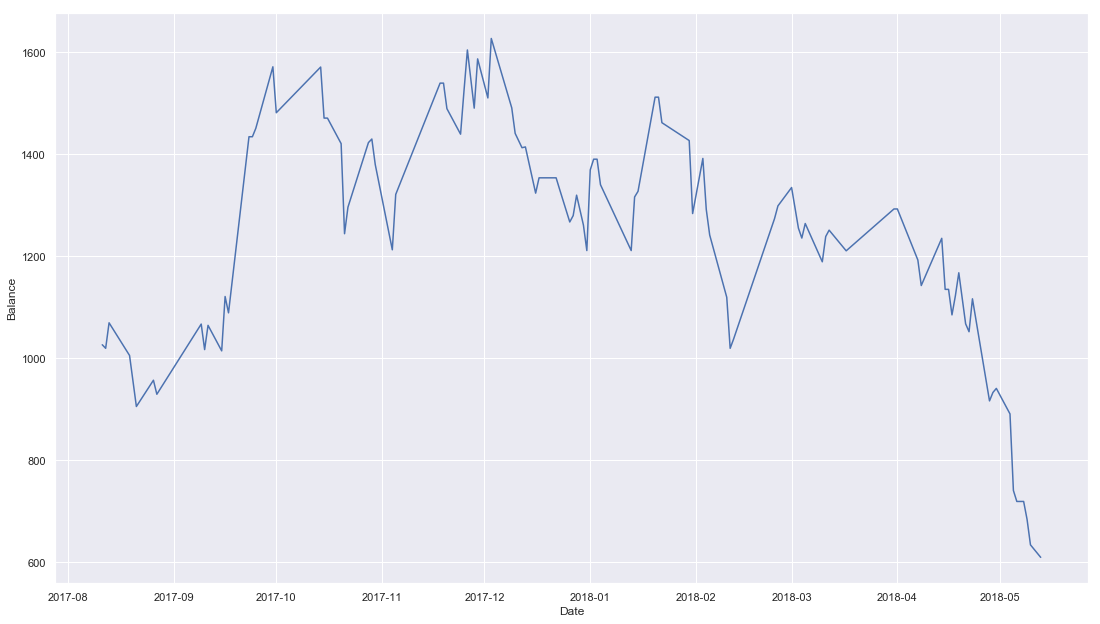

In [14]:
%matplotlib inline
import seaborn as sns
sns.set()
print(max(df_sim['Balance']))
print(min(df_sim['Balance']))
g = sns.lineplot(data=df_sim, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

In [15]:
fixtures_2016 = pd.DataFrame(df[df['Year'] == validate_year])
fixtures_2016['Date'] = pd.to_datetime(fixtures_2016['Date'], dayfirst=True)
fixtures_2016.sort_values(['Date'], inplace=True)
# fixtures_2016.dropna(subset=['Year'], inplace=True)
fixtures_2016
df_sim_2016 = naive_method(fixtures_2016)
df_sim_2016

Starting balance: 1000
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 950
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 Pay: -50 on Everton in [ Everton vs Tottenham ] Pred: Lose Actual: Draw Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Draw Balance: 987.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 937.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 980.0
2016-08-15 Receive: 82.5

2016-10-23 Receive: 107.5 Odd: 2.15 Balance: 1778.0
2016-10-23 Pay: -50 on Man City in [ Man City vs Southampton ] Pred: Win Actual: Draw Balance: 1728.0
2016-10-29 Pay: -50 on Watford in [ Watford vs Hull ] Pred: Win Actual: Win Balance: 1678.0
2016-10-29 Receive: 87.5 Odd: 1.75 Balance: 1765.5
2016-10-29 Pay: -50 on Man City in [ West Brom vs Man City ] Pred: Win Actual: Win Balance: 1715.5
2016-10-29 Receive: 72.0 Odd: 1.44 Balance: 1787.5
2016-10-29 Pay: -50 on Leicester in [ Tottenham vs Leicester ] Pred: Lose Actual: Draw Balance: 1737.5
2016-10-29 Pay: -50 on Arsenal in [ Sunderland vs Arsenal ] Pred: Win Actual: Win Balance: 1687.5
2016-10-29 Receive: 70.0 Odd: 1.4 Balance: 1757.5
2016-10-29 Pay: -50 on Bournemouth in [ Middlesbrough vs Bournemouth ] Pred: Lose Actual: Lose Balance: 1707.5
2016-10-29 Receive: 160.0 Odd: 3.2 Balance: 1867.5
2016-10-29 Pay: -50 on Burnley in [ Man United vs Burnley ] Pred: Lose Actual: Draw Balance: 1817.5
2016-10-29 Pay: -50 on Liverpool in [ Cr

2017-01-31 Pay: -50 on Southampton in [ Swansea vs Southampton ] Pred: Win Actual: Lose Balance: 1396.0
2017-02-01 Pay: -50 on Man United in [ Man United vs Hull ] Pred: Win Actual: Draw Balance: 1346.0
2017-02-01 Pay: -50 on Man City in [ West Ham vs Man City ] Pred: Win Actual: Win Balance: 1296.0
2017-02-01 Receive: 78.5 Odd: 1.57 Balance: 1374.5
2017-02-04 Pay: -50 on Watford in [ Watford vs Burnley ] Pred: Win Actual: Win Balance: 1324.5
2017-02-04 Receive: 107.5 Odd: 2.15 Balance: 1432.0
2017-02-04 Pay: -50 on Tottenham in [ Tottenham vs Middlesbrough ] Pred: Win Actual: Win Balance: 1382.0
2017-02-04 Receive: 64.5 Odd: 1.29 Balance: 1446.5
2017-02-04 Pay: -50 on Southampton in [ Southampton vs West Ham ] Pred: Win Actual: Lose Balance: 1396.5
2017-02-04 Pay: -50 on Everton in [ Everton vs Bournemouth ] Pred: Win Actual: Win Balance: 1346.5
2017-02-04 Receive: 85.0 Odd: 1.7 Balance: 1431.5
2017-02-04 Pay: -50 on Crystal Palace in [ Crystal Palace vs Sunderland ] Pred: Win Actual:

2017-05-12 Pay: -50 on Chelsea in [ West Brom vs Chelsea ] Pred: Win Actual: Win Balance: 2138.5
2017-05-12 Receive: 68.0 Odd: 1.36 Balance: 2206.5
2017-05-13 Pay: -50 on Southampton in [ Middlesbrough vs Southampton ] Pred: Win Actual: Win Balance: 2156.5
2017-05-13 Receive: 100.0 Odd: 2.0 Balance: 2256.5
2017-05-13 Pay: -50 on Swansea in [ Sunderland vs Swansea ] Pred: Win Actual: Win Balance: 2206.5
2017-05-13 Receive: 95.5 Odd: 1.91 Balance: 2302.0
2017-05-13 Pay: -50 on Man City in [ Man City vs Leicester ] Pred: Win Actual: Win Balance: 2252.0
2017-05-13 Receive: 62.5 Odd: 1.25 Balance: 2314.5
2017-05-14 Pay: -50 on Crystal Palace in [ Crystal Palace vs Hull ] Pred: Draw Actual: Win Balance: 2264.5
2017-05-14 Pay: -50 on Tottenham in [ Tottenham vs Man United ] Pred: Win Actual: Win Balance: 2214.5
2017-05-14 Receive: 86.5 Odd: 1.73 Balance: 2301.0
2017-05-14 Pay: -50 on Liverpool in [ West Ham vs Liverpool ] Pred: Win Actual: Win Balance: 2251.0
2017-05-14 Receive: 85.0 Odd: 1.7

,Date,Balance,Year,MatchDay
0,2016-08-13,987.5,2016,0
1,2016-08-14,1030.0,2016,1
2,2016-08-15,1062.5,2016,2
3,2016-08-19,1089.0,2016,3
4,2016-08-20,1048.0,2016,4
5,2016-08-21,1095.5,2016,5
6,2016-08-27,1066.5,2016,6
7,2016-08-28,1029.0,2016,7
8,2016-09-10,995.0,2016,8
9,2016-09-11,995.0,2016,9


2419.0
987.5


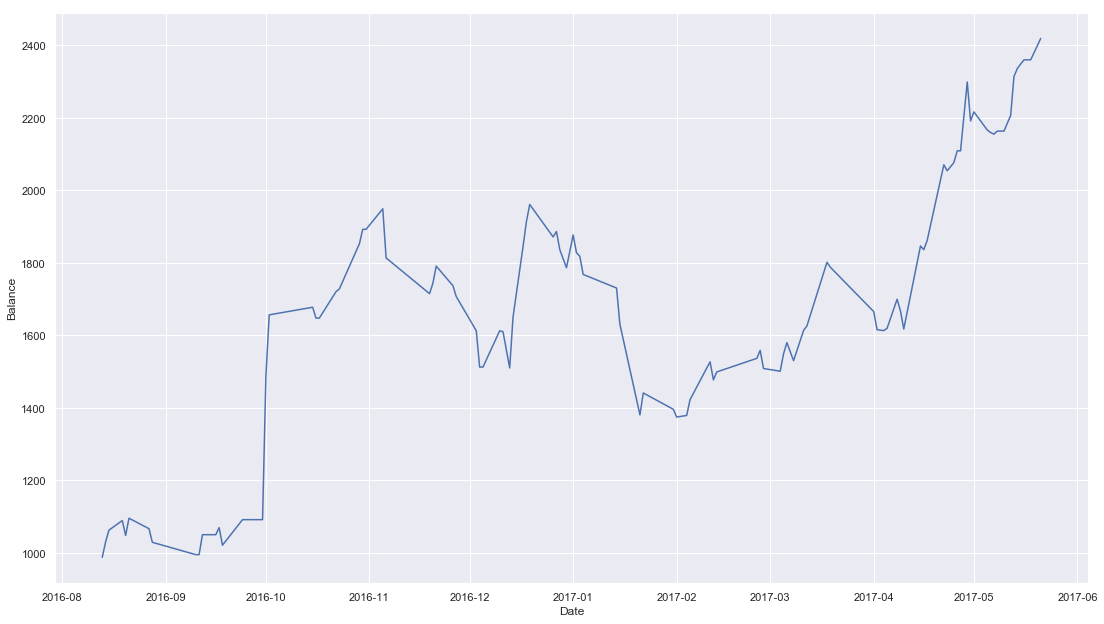

In [16]:
%matplotlib inline
import seaborn as sns
sns.set()
print(max(df_sim_2016['Balance']))
print(min(df_sim_2016['Balance']))
g = sns.lineplot(data=df_sim_2016, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

Starting balance: 1000
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 950
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 Pay: -50 on Everton in [ Everton vs Tottenham ] Pred: Lose Actual: Draw Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Draw Balance: 987.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 937.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 980.0
2016-08-15 Receive: 82.5

2016-12-10 Pay: -50 on Swansea in [ Swansea vs Sunderland ] Pred: Win Actual: Win Balance: 1462.5
2016-12-10 Receive: 107.5 Odd: 2.15 Balance: 1570.0
2016-12-10 Pay: -50 on Leicester in [ Leicester vs Man City ] Pred: Lose Actual: Win Balance: 1520.0
2016-12-10 Pay: -50 on Arsenal in [ Arsenal vs Stoke ] Pred: Win Actual: Win Balance: 1470.0
2016-12-10 Receive: 67.5 Odd: 1.35 Balance: 1537.5
2016-12-10 Pay: -50 on Burnley in [ Burnley vs Bournemouth ] Pred: Win Actual: Win Balance: 1487.5
2016-12-10 Receive: 175.0 Odd: 3.5 Balance: 1662.5
2016-12-10 Pay: -50 on Crystal Palace in [ Hull vs Crystal Palace ] Pred: Win Actual: Draw Balance: 1612.5
2016-12-11 Pay: -50 on Chelsea in [ Chelsea vs West Brom ] Pred: Win Actual: Win Balance: 1562.5
2016-12-11 Receive: 62.5 Odd: 1.25 Balance: 1625.0
2016-12-11 Pay: -50 on Liverpool in [ Liverpool vs West Ham ] Pred: Win Actual: Draw Balance: 1575.0
2016-12-11 Pay: -50 on Southampton in [ Southampton vs Middlesbrough ] Pred: Win Actual: Win Balanc

2017-03-18 Pay: -50 on Arsenal in [ West Brom vs Arsenal ] Pred: Win Actual: Lose Balance: 1526.0
2017-03-18 Pay: -50 on Chelsea in [ Stoke vs Chelsea ] Pred: Win Actual: Win Balance: 1476.0
2017-03-18 Receive: 81.0 Odd: 1.62 Balance: 1557.0
2017-03-18 Pay: -50 on Leicester in [ West Ham vs Leicester ] Pred: Win Actual: Win Balance: 1507.0
2017-03-18 Receive: 165.0 Odd: 3.3 Balance: 1672.0
2017-03-18 Pay: -50 on Crystal Palace in [ Crystal Palace vs Watford ] Pred: Win Actual: Win Balance: 1622.0
2017-03-18 Receive: 95.5 Odd: 1.91 Balance: 1717.5
2017-03-18 Pay: -50 on Bournemouth in [ Bournemouth vs Swansea ] Pred: Win Actual: Win Balance: 1667.5
2017-03-18 Receive: 107.5 Odd: 2.15 Balance: 1775.0
2017-03-18 Pay: -50 on Everton in [ Everton vs Hull ] Pred: Win Actual: Win Balance: 1725.0
2017-03-18 Receive: 76.5 Odd: 1.53 Balance: 1801.5
2017-03-19 Pay: -50 on Tottenham in [ Tottenham vs Southampton ] Pred: Win Actual: Win Balance: 1751.5
2017-03-19 Receive: 86.5 Odd: 1.73 Balance: 18

2017-08-26 Pay: -50 on Watford in [ Watford vs Brighton ] Pred: Draw Actual: Draw Balance: 2224.5
2017-08-26 Receive: 170.0 Odd: 3.4 Balance: 2394.5
2017-08-26 Pay: -50 on Man United in [ Man United vs Leicester ] Pred: Win Actual: Win Balance: 2344.5
2017-08-26 Receive: 66.5 Odd: 1.33 Balance: 2411.0
2017-08-26 Pay: -50 on Man City in [ Bournemouth vs Man City ] Pred: Win Actual: Win Balance: 2361.0
2017-08-26 Receive: 65.0 Odd: 1.3 Balance: 2426.0
2017-08-26 Pay: -50 on Southampton in [ Huddersfield vs Southampton ] Pred: Win Actual: Draw Balance: 2376.0
2017-08-27 Pay: -50 on Chelsea in [ Chelsea vs Everton ] Pred: Win Actual: Win Balance: 2326.0
2017-08-27 Receive: 72.5 Odd: 1.45 Balance: 2398.5
2017-08-27 Pay: -50 on Burnley in [ Tottenham vs Burnley ] Pred: Lose Actual: Draw Balance: 2348.5
2017-09-09 Pay: -50 on Chelsea in [ Leicester vs Chelsea ] Pred: Win Actual: Win Balance: 2298.5
2017-09-09 Receive: 90.0 Odd: 1.8 Balance: 2388.5
2017-09-09 Pay: -50 on Man United in [ Stoke 

2017-12-02 Receive: 62.5 Odd: 1.25 Balance: 2918.0
2017-12-02 Pay: -50 on Liverpool in [ Brighton vs Liverpool ] Pred: Win Actual: Win Balance: 2868.0
2017-12-02 Receive: 75.0 Odd: 1.5 Balance: 2943.0
2017-12-02 Pay: -50 on Arsenal in [ Arsenal vs Man United ] Pred: Draw Actual: Lose Balance: 2893.0
2017-12-02 Pay: -50 on Everton in [ Everton vs Huddersfield ] Pred: Win Actual: Win Balance: 2843.0
2017-12-02 Receive: 86.0 Odd: 1.72 Balance: 2929.0
2017-12-03 Pay: -50 on Bournemouth in [ Bournemouth vs Southampton ] Pred: Win Actual: Win Balance: 2879.0
2017-12-03 Receive: 162.5 Odd: 3.25 Balance: 3041.5
2017-12-03 Pay: -50 on Man City in [ Man City vs West Ham ] Pred: Win Actual: Win Balance: 2991.5
2017-12-03 Receive: 54.0 Odd: 1.08 Balance: 3045.5
2017-12-09 Pay: -50 on Chelsea in [ West Ham vs Chelsea ] Pred: Win Actual: Lose Balance: 2995.5
2017-12-09 Pay: -50 on Burnley in [ Burnley vs Watford ] Pred: Lose Actual: Win Balance: 2945.5
2017-12-09 No bet in [ Huddersfield vs Brighton

2018-03-10 Pay: -50 on Southampton in [ Newcastle vs Southampton ] Pred: Win Actual: Lose Balance: 2633.0
2018-03-10 Pay: -50 on Burnley in [ West Ham vs Burnley ] Pred: Lose Actual: Win Balance: 2583.0
2018-03-10 Pay: -50 on Everton in [ Everton vs Brighton ] Pred: Win Actual: Win Balance: 2533.0
2018-03-10 Receive: 110.00000000000001 Odd: 2.2 Balance: 2643.0
2018-03-10 Pay: -50 on Chelsea in [ Chelsea vs Crystal Palace ] Pred: Win Actual: Win Balance: 2593.0
2018-03-10 Receive: 65.0 Odd: 1.3 Balance: 2658.0
2018-03-10 Pay: -50 on Swansea in [ Huddersfield vs Swansea ] Pred: Win Actual: Draw Balance: 2608.0
2018-03-11 Pay: -50 on Arsenal in [ Arsenal vs Watford ] Pred: Win Actual: Win Balance: 2558.0
2018-03-11 Receive: 72.0 Odd: 1.44 Balance: 2630.0
2018-03-11 Pay: -50 on Tottenham in [ Bournemouth vs Tottenham ] Pred: Win Actual: Win Balance: 2580.0
2018-03-11 Receive: 77.5 Odd: 1.55 Balance: 2657.5
2018-03-12 Pay: -50 on Man City in [ Stoke vs Man City ] Pred: Win Actual: Win Balan

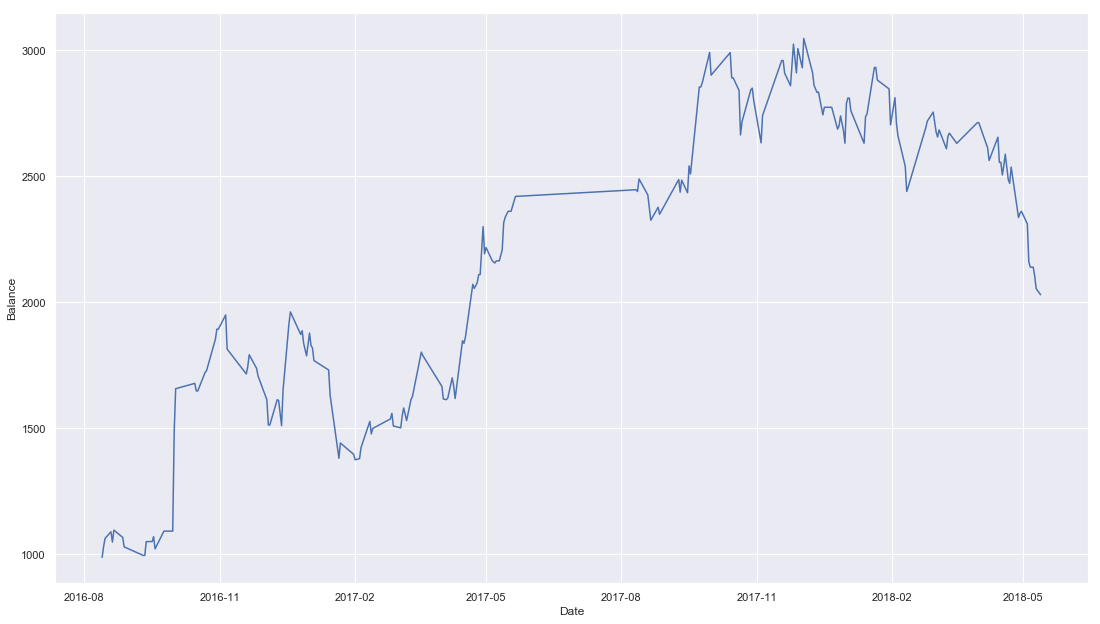

In [17]:
df_sim_2016_2017 = naive_method(fixtures_2016)
df_sim_2016_2017 = df_sim_2016_2017.append(naive_method(fixtures, df_sim_2016_2017['Balance'].values[-1]))
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_2016_2017, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

Starting balance: 1000
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 950
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 Pay: -50 on Everton in [ Everton vs Tottenham ] Pred: Lose Actual: Draw Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Draw Balance: 987.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 937.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win Balance: 980.0
2016-08-15 Receive: 82.5

2016-12-10 Pay: -50 on Burnley in [ Burnley vs Bournemouth ] Pred: Win Actual: Win Balance: 1487.5
2016-12-10 Receive: 175.0 Odd: 3.5 Balance: 1662.5
2016-12-10 Pay: -50 on Crystal Palace in [ Hull vs Crystal Palace ] Pred: Win Actual: Draw Balance: 1612.5
2016-12-11 Pay: -50 on Chelsea in [ Chelsea vs West Brom ] Pred: Win Actual: Win Balance: 1562.5
2016-12-11 Receive: 62.5 Odd: 1.25 Balance: 1625.0
2016-12-11 Pay: -50 on Liverpool in [ Liverpool vs West Ham ] Pred: Win Actual: Draw Balance: 1575.0
2016-12-11 Pay: -50 on Southampton in [ Southampton vs Middlesbrough ] Pred: Win Actual: Win Balance: 1525.0
2016-12-11 Receive: 85.0 Odd: 1.7 Balance: 1610.0
2016-12-13 Pay: -50 on Bournemouth in [ Bournemouth vs Leicester ] Pred: Lose Actual: Win Balance: 1560.0
2016-12-13 Pay: -50 on Arsenal in [ Everton vs Arsenal ] Pred: Win Actual: Lose Balance: 1510.0
2016-12-14 Pay: -50 on West Ham in [ West Ham vs Burnley ] Pred: Win Actual: Win Balance: 1460.0
2016-12-14 Receive: 83.5 Odd: 1.67 B

2017-03-18 Pay: -50 on Burnley in [ Sunderland vs Burnley ] Pred: Lose Actual: Draw Balance: 1576.0
2017-03-18 Pay: -50 on Arsenal in [ West Brom vs Arsenal ] Pred: Win Actual: Lose Balance: 1526.0
2017-03-18 Pay: -50 on Chelsea in [ Stoke vs Chelsea ] Pred: Win Actual: Win Balance: 1476.0
2017-03-18 Receive: 81.0 Odd: 1.62 Balance: 1557.0
2017-03-18 Pay: -50 on Leicester in [ West Ham vs Leicester ] Pred: Win Actual: Win Balance: 1507.0
2017-03-18 Receive: 165.0 Odd: 3.3 Balance: 1672.0
2017-03-18 Pay: -50 on Crystal Palace in [ Crystal Palace vs Watford ] Pred: Win Actual: Win Balance: 1622.0
2017-03-18 Receive: 95.5 Odd: 1.91 Balance: 1717.5
2017-03-18 Pay: -50 on Bournemouth in [ Bournemouth vs Swansea ] Pred: Win Actual: Win Balance: 1667.5
2017-03-18 Receive: 107.5 Odd: 2.15 Balance: 1775.0
2017-03-18 Pay: -50 on Everton in [ Everton vs Hull ] Pred: Win Actual: Win Balance: 1725.0
2017-03-18 Receive: 76.5 Odd: 1.53 Balance: 1801.5
2017-03-19 Pay: -50 on Tottenham in [ Tottenham v

2017-09-09 Pay: -50 on Man United in [ Stoke vs Man United ] Pred: Win Actual: Draw Balance: 919.5
2017-09-09 Pay: -50 on Southampton in [ Southampton vs Watford ] Pred: Win Actual: Lose Balance: 869.5
2017-09-09 Pay: -50 on Man City in [ Man City vs Liverpool ] Pred: Win Actual: Win Balance: 819.5
2017-09-09 Receive: 92.5 Odd: 1.85 Balance: 912.0
2017-09-09 Pay: -50 on Tottenham in [ Everton vs Tottenham ] Pred: Win Actual: Win Balance: 862.0
2017-09-09 Receive: 105.0 Odd: 2.1 Balance: 967.0
2017-09-09 Pay: -50 on West Brom in [ Brighton vs West Brom ] Pred: Lose Actual: Lose Balance: 917.0
2017-09-09 Receive: 150.0 Odd: 3.0 Balance: 1067.0
2017-09-10 Pay: -50 on Swansea in [ Swansea vs Newcastle ] Pred: Win Actual: Lose Balance: 1017.0
2017-09-11 Pay: -50 on West Ham in [ West Ham vs Huddersfield ] Pred: Win Actual: Win Balance: 967.0
2017-09-11 Receive: 97.5 Odd: 1.95 Balance: 1064.5
2017-09-15 Pay: -50 on Bournemouth in [ Bournemouth vs Brighton ] Pred: Draw Actual: Win Balance: 10

2017-12-13 Pay: -50 on Man United in [ Man United vs Bournemouth ] Pred: Win Actual: Win Balance: 1287.5
2017-12-13 Receive: 64.0 Odd: 1.28 Balance: 1351.5
2017-12-13 Pay: -50 on Liverpool in [ Liverpool vs West Brom ] Pred: Win Actual: Draw Balance: 1301.5
2017-12-13 Pay: -50 on Everton in [ Newcastle vs Everton ] Pred: Win Actual: Win Balance: 1251.5
2017-12-13 Receive: 162.5 Odd: 3.25 Balance: 1414.0
2017-12-16 Pay: -50 on Arsenal in [ Arsenal vs Newcastle ] Pred: Win Actual: Win Balance: 1364.0
2017-12-16 Receive: 62.5 Odd: 1.25 Balance: 1426.5
2017-12-16 Pay: -50 on Burnley in [ Brighton vs Burnley ] Pred: Lose Actual: Draw Balance: 1376.5
2017-12-16 Pay: -50 on Chelsea in [ Chelsea vs Southampton ] Pred: Win Actual: Win Balance: 1326.5
2017-12-16 Receive: 69.5 Odd: 1.39 Balance: 1396.0
2017-12-16 Pay: -50 on Man City in [ Man City vs Tottenham ] Pred: Win Actual: Win Balance: 1346.0
2017-12-16 Receive: 77.5 Odd: 1.55 Balance: 1423.5
2017-12-16 Pay: -50 on Stoke in [ Stoke vs West

2018-04-07 No bet in [ Brighton vs Huddersfield ] Balance: 1242.5
2018-04-07 Pay: -50 on Leicester in [ Leicester vs Newcastle ] Pred: Draw Actual: Lose Balance: 1192.5
2018-04-08 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Draw Balance: 1142.5
2018-04-14 Pay: -50 on Man City in [ Tottenham vs Man City ] Pred: Win Actual: Win Balance: 1092.5
2018-04-14 Receive: 135.0 Odd: 2.7 Balance: 1227.5
2018-04-14 Pay: -50 on Crystal Palace in [ Crystal Palace vs Brighton ] Pred: Win Actual: Win Balance: 1177.5
2018-04-14 Receive: 95.0 Odd: 1.9 Balance: 1272.5
2018-04-14 Pay: -50 on Watford in [ Huddersfield vs Watford ] Pred: Win Actual: Lose Balance: 1222.5
2018-04-14 Pay: -50 on Liverpool in [ Liverpool vs Bournemouth ] Pred: Win Actual: Win Balance: 1172.5
2018-04-14 Receive: 62.5 Odd: 1.25 Balance: 1235.0
2018-04-15 Pay: -50 on Arsenal in [ Newcastle vs Arsenal ] Pred: Draw Actual: Lose Balance: 1185.0
2018-04-15 Pay: -50 on Man United in [ Man United vs West Brom ] Pred:

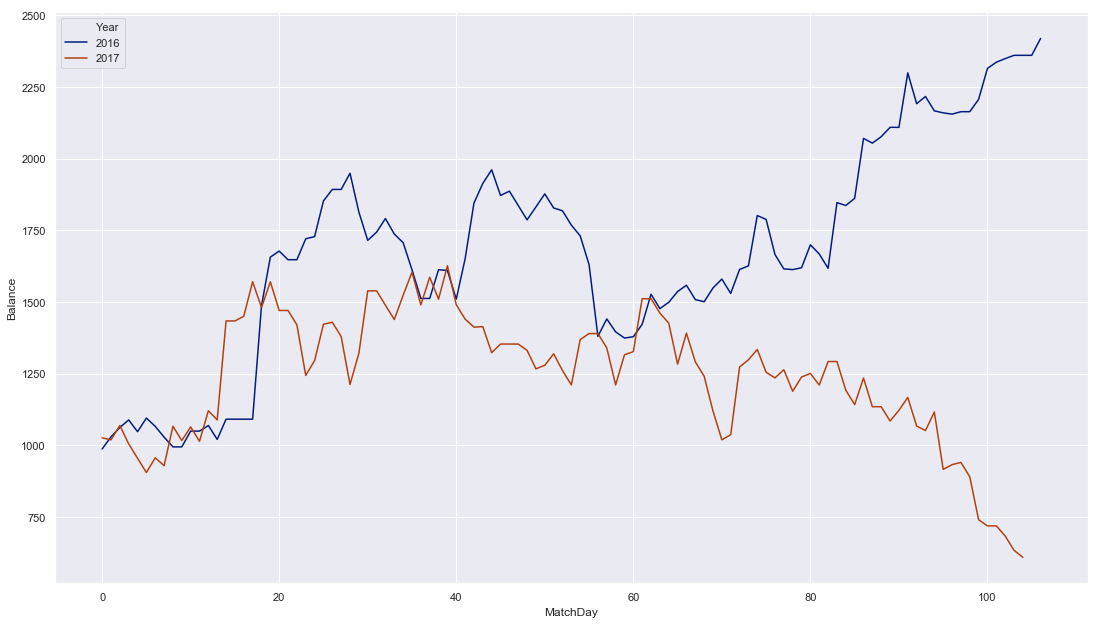

In [18]:
df_sim_all = naive_method(fixtures_2016)
df_sim_all = df_sim_all.append(naive_method(fixtures))
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_all, x='MatchDay', y='Balance', hue='Year', palette=sns.color_palette("dark", 2))
g.figure.set_size_inches(18.5, 10.5)

In [19]:
df_sim_all[df_sim_all['Year'] == 2016]

,Date,Balance,Year,MatchDay
0,2016-08-13,987.5,2016,0
1,2016-08-14,1030.0,2016,1
2,2016-08-15,1062.5,2016,2
3,2016-08-19,1089.0,2016,3
4,2016-08-20,1048.0,2016,4
5,2016-08-21,1095.5,2016,5
6,2016-08-27,1066.5,2016,6
7,2016-08-28,1029.0,2016,7
8,2016-09-10,995.0,2016,8
9,2016-09-11,995.0,2016,9


In [37]:
def next_draw_method(fixtures, starting_balance=1000):
#     starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = []
    dates = []
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            d = date.date().strftime('%Y-%m-%d')
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                balance += bet
                print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred = ''
                act = ''
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)
                odd = 0
                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

#                     balance += bet
#                     print('what', len(predictions), balance)
#                     print(match)
#                     odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        pred = pred_one
                        act = act_one
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        pred = pred_one
                        act = act_one
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        pred = pred_two
                        act = act_two
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two, 'Balance:', balance)
                    else:
                        team = predictions['Team'].values[0]
#                         print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one, 'Balance:', balance)
                elif pred_one == 'Draw' or pred_two == 'Draw':
                    # if one of them predict Draw but the other does not, find next best
                    if pred_one == 'Draw':
                        lose_prob_two = predictions['LoseProb'].values[1]
                        win_prob_two = predictions['WinProb'].values[1]
                        if lose_prob_two > win_prob_two:
                            # guess a draw
                            team = predictions['Team'].values[0]
                            pred = 'Draw'
                            if act_one == 'Draw':
                                odd = match['B365D']
#                         else:
#                             # do nothing
#                             pass
                    else:
                        lose_prob_one = predictions['LoseProb'].values[0]
                        win_prob_one = predictions['WinProb'].values[0]
                        if lose_prob_one > win_prob_one:
                            # guess a draw
                            team = predictions['Team'].values[1]
                            pred = 'Draw'
                            if act_one == 'Draw':
                                odd = match['B365D']
                elif pred_one == pred_two == 'Lose':
                    # if both are losers, bet on draw
                    team = predictions['Team'].values[0]
                    pred = 'Draw'
                    if act_one == 'Draw':
                        odd = match['B365D']
                    act = act_one
                if pred != '':
                    balance += bet
                    print(d, "Pay:", bet, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act, 'Balance:', balance)
                else:
                    print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
                    
                if odd != 0:
                    receive = bet * odd * -1
                    balance += receive
                    print(d, "Receive:", receive, "Odd:", odd, "Balance:", balance)
                

            else:
                print(d, "No bet in [", match['HomeTeam'], 'vs', match['AwayTeam'], "] Balance:", balance)
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
    print("Ending balance:", balance)
    year = dates[0].date().year
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances,
        'Year': year,
        'MatchDay': range(0, len(dates))
    })
    return df_sim

Starting balance: 1000
2017-08-11 Pay: -50 on Arsenal in [ Arsenal vs Leicester ] Pred: Win Actual: Win Balance: 950
2017-08-11 Receive: 76.5 Odd: 1.53 Balance: 1026.5
2017-08-12 Pay: -50 on Man City in [ Brighton vs Man City ] Pred: Win Actual: Win Balance: 976.5
2017-08-12 Receive: 66.5 Odd: 1.33 Balance: 1043.0
2017-08-12 No bet in [ Chelsea vs Burnley ] Balance: 1043.0
2017-08-12 Pay: -50 on Crystal Palace in [ Crystal Palace vs Huddersfield ] Pred: Lose Actual: Lose Balance: 993.0
2017-08-12 Receive: 91.5 Odd: 1.83 Balance: 1084.5
2017-08-12 Pay: -50 on Everton in [ Everton vs Stoke ] Pred: Win Actual: Win Balance: 1034.5
2017-08-12 Receive: 85.0 Odd: 1.7 Balance: 1119.5
2017-08-12 No bet in [ Southampton vs Swansea ] Balance: 1119.5
2017-08-12 No bet in [ Watford vs Liverpool ] Balance: 1119.5
2017-08-12 Pay: -50 on Bournemouth in [ West Brom vs Bournemouth ] Pred: Draw Actual: Lose Balance: 1069.5
2017-08-13 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: 

2017-10-15 Pay: -50 on Southampton in [ Southampton vs Newcastle ] Pred: Win Actual: Draw Balance: 2083.0
2017-10-16 No bet in [ Leicester vs West Brom ] Balance: 2083.0
2017-10-20 Pay: -50 on West Ham in [ West Ham vs Brighton ] Pred: Win Actual: Lose Balance: 2033.0
2017-10-21 Pay: -50 on Chelsea in [ Chelsea vs Watford ] Pred: Win Actual: Win Balance: 1983.0
2017-10-21 Receive: 68.0 Odd: 1.36 Balance: 2051.0
2017-10-21 Pay: -50 on Man United in [ Huddersfield vs Man United ] Pred: Win Actual: Lose Balance: 2001.0
2017-10-21 Pay: -50 on Man City in [ Man City vs Burnley ] Pred: Win Actual: Win Balance: 1951.0
2017-10-21 Receive: 55.50000000000001 Odd: 1.11 Balance: 2006.5
2017-10-21 Pay: -50 on Crystal Palace in [ Newcastle vs Crystal Palace ] Pred: Draw Actual: Lose Balance: 1956.5
2017-10-21 No bet in [ Southampton vs West Brom ] Balance: 1956.5
2017-10-21 No bet in [ Stoke vs Bournemouth ] Balance: 1956.5
2017-10-21 No bet in [ Swansea vs Leicester ] Balance: 1956.5
2017-10-22 Pay

2018-01-01 Pay: -50 on Bournemouth in [ Brighton vs Bournemouth ] Pred: Draw Actual: Draw Balance: 2631.5
2018-01-01 Receive: 160.0 Odd: 3.2 Balance: 2791.5
2018-01-01 Pay: -50 on Man United in [ Everton vs Man United ] Pred: Win Actual: Win Balance: 2741.5
2018-01-01 Receive: 90.0 Odd: 1.8 Balance: 2831.5
2018-01-02 Pay: -50 on Man City in [ Man City vs Watford ] Pred: Win Actual: Win Balance: 2781.5
2018-01-02 Receive: 56.00000000000001 Odd: 1.12 Balance: 2837.5
2018-01-02 No bet in [ Southampton vs Crystal Palace ] Balance: 2837.5
2018-01-02 Pay: -50 on Tottenham in [ Swansea vs Tottenham ] Pred: Win Actual: Win Balance: 2787.5
2018-01-02 Receive: 65.0 Odd: 1.3 Balance: 2852.5
2018-01-02 No bet in [ West Ham vs West Brom ] Balance: 2852.5
2018-01-03 Pay: -50 on Arsenal in [ Arsenal vs Chelsea ] Pred: Draw Actual:  Balance: 2802.5
2018-01-03 Receive: 169.5 Odd: 3.39 Balance: 2972.0
2018-01-04 No bet in [ Tottenham vs West Ham ] Balance: 2972.0
2018-01-13 Pay: -50 on West Ham in [ Hud

2018-04-30 Receive: 57.99999999999999 Odd: 1.16 Balance: 3658.0
2018-05-04 Pay: -50 on Man United in [ Brighton vs Man United ] Pred: Win Actual: Lose Balance: 3608.0
2018-05-05 Pay: -50 on Watford in [ Watford vs Newcastle ] Pred: Lose Actual: Win Balance: 3558.0
2018-05-05 No bet in [ West Brom vs Tottenham ] Balance: 3558.0
2018-05-05 No bet in [ Stoke vs Crystal Palace ] Balance: 3558.0
2018-05-05 No bet in [ Everton vs Southampton ] Balance: 3558.0
2018-05-05 No bet in [ Bournemouth vs Swansea ] Balance: 3558.0
2018-05-05 Pay: -50 on Leicester in [ Leicester vs West Ham ] Pred: Draw Actual:  Balance: 3508.0
2018-05-06 Pay: -50 on Arsenal in [ Arsenal vs Burnley ] Pred: Win Actual: Win Balance: 3458.0
2018-05-06 Receive: 78.5 Odd: 1.57 Balance: 3536.5
2018-05-06 No bet in [ Chelsea vs Liverpool ] Balance: 3536.5
2018-05-06 Pay: -50 on Man City in [ Man City vs Huddersfield ] Pred: Win Actual: Draw Balance: 3486.5
2018-05-08 No bet in [ Swansea vs Southampton ] Balance: 3486.5
2018-

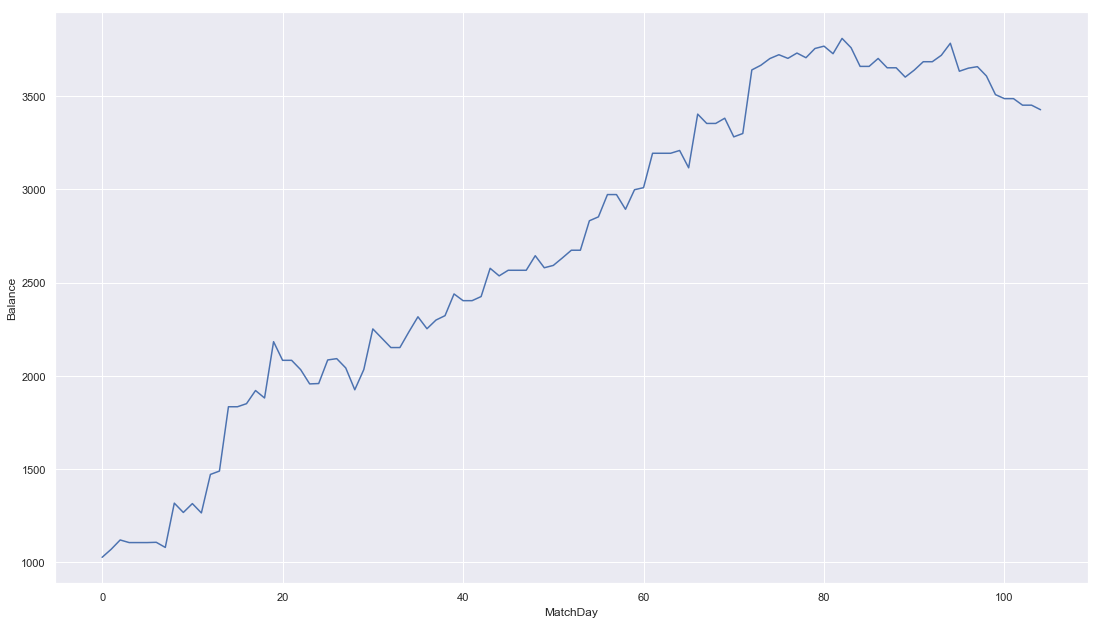

In [38]:
df_sim_nd_2017 = next_draw_method(fixtures)
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2017, x='MatchDay', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

Starting balance: 1000
2016-08-13 Pay: -50 on Burnley in [ Burnley vs Swansea ] Pred: Draw Actual:  Balance: 950
2016-08-13 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win Balance: 900
2016-08-13 Receive: 225.0 Odd: 4.5 Balance: 1125.0
2016-08-13 No bet in [ Everton vs Tottenham ] Balance: 1125.0
2016-08-13 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose Balance: 1075.0
2016-08-13 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win Balance: 1025.0
2016-08-13 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw Balance: 1037.5
2016-08-13 No bet in [ Southampton vs Watford ] Balance: 1037.5
2016-08-14 No bet in [ Arsenal vs Liverpool ] Balance: 1037.5
2016-08-14 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win Balance: 987.5
2016-08-14 Receive: 92.5 Odd: 1.85 Balance: 1080.0
2016-08-15 Pay: -50 on Chelsea in [ Chelsea

2016-10-15 Pay: -50 on Chelsea in [ Chelsea vs Leicester ] Pred: Win Actual: Win Balance: 1916.5
2016-10-15 Receive: 78.5 Odd: 1.57 Balance: 1995.0
2016-10-15 Pay: -50 on Bournemouth in [ Bournemouth vs Hull ] Pred: Win Actual: Win Balance: 1945.0
2016-10-15 Receive: 92.5 Odd: 1.85 Balance: 2037.5
2016-10-15 Pay: -50 on Crystal Palace in [ Crystal Palace vs West Ham ] Pred: Draw Actual: Lose Balance: 1987.5
2016-10-16 Pay: -50 on Watford in [ Middlesbrough vs Watford ] Pred: Draw Actual: Win Balance: 1937.5
2016-10-16 Pay: -50 on Southampton in [ Southampton vs Burnley ] Pred: Win Actual: Win Balance: 1887.5
2016-10-16 Receive: 70.0 Odd: 1.4 Balance: 1957.5
2016-10-17 No bet in [ Liverpool vs Man United ] Balance: 1957.5
2016-10-22 Pay: -50 on Arsenal in [ Arsenal vs Middlesbrough ] Pred: Win Actual: Draw Balance: 1907.5
2016-10-22 Pay: -50 on Bournemouth in [ Bournemouth vs Tottenham ] Pred: Draw Actual: Draw Balance: 1857.5
2016-10-22 Receive: 180.0 Odd: 3.6 Balance: 2037.5
2016-10-2

2017-01-14 Pay: -50 on Burnley in [ Burnley vs Southampton ] Pred: Draw Actual: Win Balance: 3039.5
2017-01-14 Pay: -50 on Bournemouth in [ Hull vs Bournemouth ] Pred: Lose Actual: Lose Balance: 2989.5
2017-01-14 Receive: 114.99999999999999 Odd: 2.3 Balance: 3104.5
2017-01-14 Pay: -50 on Watford in [ Watford vs Middlesbrough ] Pred: Win Actual: Draw Balance: 3054.5
2017-01-14 Pay: -50 on Chelsea in [ Leicester vs Chelsea ] Pred: Win Actual: Win Balance: 3004.5
2017-01-14 Receive: 81.0 Odd: 1.62 Balance: 3085.5
2017-01-14 No bet in [ West Ham vs Crystal Palace ] Balance: 3085.5
2017-01-15 No bet in [ Man United vs Liverpool ] Balance: 3085.5
2017-01-15 No bet in [ Everton vs Man City ] Balance: 3085.5
2017-01-21 Pay: -50 on West Brom in [ West Brom vs Sunderland ] Pred: Draw Actual: Win Balance: 3035.5
2017-01-21 Pay: -50 on Stoke in [ Stoke vs Man United ] Pred: Draw Actual:  Balance: 2985.5
2017-01-21 Receive: 210.0 Odd: 4.2 Balance: 3195.5
2017-01-21 Pay: -50 on West Ham in [ Middles

2017-04-26 No bet in [ Arsenal vs Leicester ] Balance: 5031.5
2017-04-26 Pay: -50 on Tottenham in [ Crystal Palace vs Tottenham ] Pred: Win Actual: Win Balance: 4981.5
2017-04-26 Receive: 82.5 Odd: 1.65 Balance: 5064.0
2017-04-27 No bet in [ Man City vs Man United ] Balance: 5064.0
2017-04-29 No bet in [ Crystal Palace vs Burnley ] Balance: 5064.0
2017-04-29 Pay: -50 on Southampton in [ Southampton vs Hull ] Pred: Draw Actual: Draw Balance: 5014.0
2017-04-29 Receive: 187.5 Odd: 3.75 Balance: 5201.5
2017-04-29 No bet in [ Stoke vs West Ham ] Balance: 5201.5
2017-04-29 Pay: -50 on Bournemouth in [ Sunderland vs Bournemouth ] Pred: Win Actual: Win Balance: 5151.5
2017-04-29 Receive: 114.99999999999999 Odd: 2.3 Balance: 5266.5
2017-04-29 Pay: -50 on Leicester in [ West Brom vs Leicester ] Pred: Win Actual: Win Balance: 5216.5
2017-04-29 Receive: 137.5 Odd: 2.75 Balance: 5354.0
2017-04-30 Pay: -50 on Tottenham in [ Tottenham vs Arsenal ] Pred: Win Actual: Win Balance: 5304.0
2017-04-30 Rece

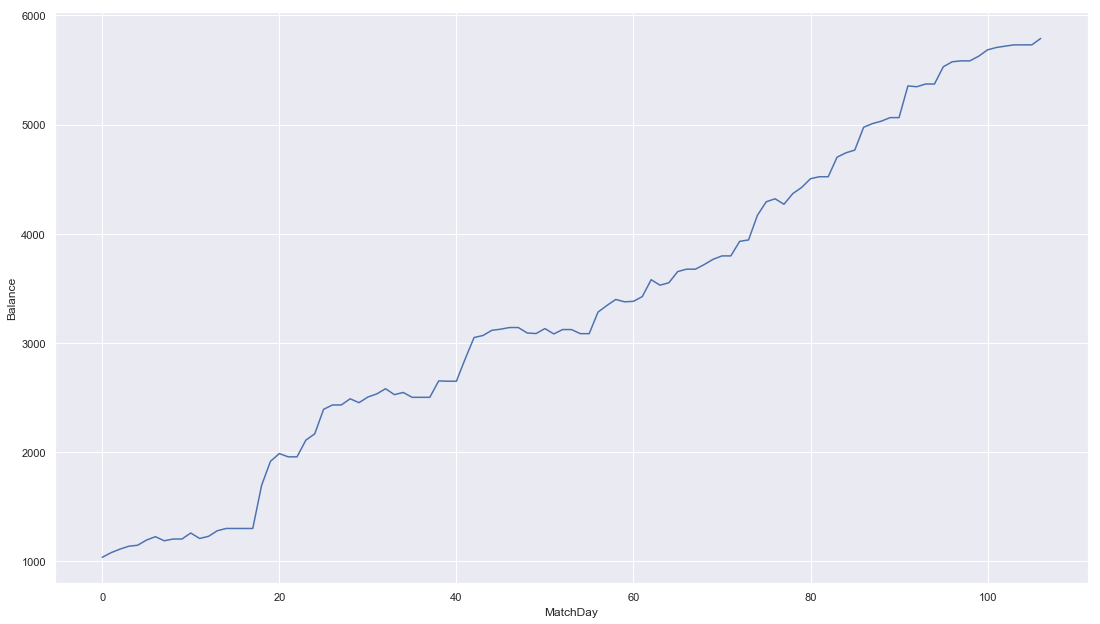

In [39]:
df_sim_nd_2016 = next_draw_method(fixtures_2016)
%matplotlib inline
import seaborn as sns
sns.set()
g = sns.lineplot(data=df_sim_nd_2016, x='MatchDay', y='Balance')
g.figure.set_size_inches(18.5, 10.5)